In [ ]:
'''
1. ライブラリのインポート
'''
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
'''
2. パラメーター値の設定
'''
batch_size = 64  # ミニバッチのサイズ
num_channels = 1 # 画像のチャネル数
num_classes = 10 # 分類先のクラス数
image_size = 28  # 画像の縦横のサイズ
latent_dim = 128 # ノイズの次元数

In [ ]:
'''
3. データセットの用意
'''
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# 画像のピクセル値を255.0で割って0～1.0の範囲にする
all_digits = all_digits.astype("float32") / 255.0
# 画像データのテンソルの形状変換: (bs, 28, 28) -> (bs, 28, 28, 1)
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
# 正解ラベルをOne-hot化する
all_labels = keras.utils.to_categorical(all_labels, 10)

# データセットを作成
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f'Shape of training images: {all_digits.shape}')
print(f'Shape of training labels: {all_labels.shape}')

11493376/11490434 [==============================] - 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [ ]:
'''
4. 生成器と識別器の入力時のチャネル数を設定
'''
# 生成器の入力チャネル数
generator_in_channels = latent_dim + num_classes
# 識別器の入力チャネル数
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels,)
print( discriminator_in_channels)

138
11


In [ ]:
'''
5. 生成器と識別器のネットワークを作成
'''
# 識別器
discriminator = keras.Sequential(
    [
        # 入力: (bs, 28, 28, 11)
        keras.layers.InputLayer((28,
                                 28,
                                 discriminator_in_channels)),
        # 畳み込み層1: (bs, 28, 28, 1)->(bs, 14, 14, 64)
        layers.Conv2D(64,            # フィルター数64
                    (3, 3),          # フィルターサイズ3×3
                    strides=(2, 2),  # ストライド2
                    padding="same"), # パディング
        # LeakyReLU関数を適用
        layers.LeakyReLU(alpha=0.2),
        # 畳み込み層2: (bs, 14, 14, 64)->(bs, 7, 7, 128)
        layers.Conv2D(128,           # フィルター数128
                    (3, 3),          # フィルターサイズ3×3
                    strides=(2, 2),  # ストライド2
                    padding="same"), # パディング
        # LeakyReLU関数を適用
        layers.LeakyReLU(alpha=0.2),
        # プーリング層: (bs, 7, 7, 128)->(bs, 128)
        layers.GlobalMaxPooling2D(),
        # 全結合層: (bs, 128)->(bs, 1)
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

# 生成器
generator = keras.Sequential(
    [
        # 入力: (bs, 138)
        keras.layers.InputLayer((generator_in_channels,)),
        # 全結合層: (bs, 6762)
        layers.Dense(7 * 7 * generator_in_channels), # ユニット数6762
        # LeakyReLU関数を適用
        layers.LeakyReLU(alpha=0.2),
        # テンソルの形状を変換: (bs, 6762)->(bs, 7, 7, 138)
        layers.Reshape((7, 7, generator_in_channels)),
        # 転置畳み込み層: (bs, 7, 7, 138)->(bs, 14, 14, 128)
        layers.Conv2DTranspose(128,             # フィルター数128
                               (4, 4),          # フィルターサイズ4×4
                               strides=(2, 2),  # ストライド2
                               padding="same"), # パディング
        # LeakyReLU関数を適用
        layers.LeakyReLU(alpha=0.2),
        # 転置畳み込み層: (bs, 14, 14, 128)->(bs, 28, 28, 128)
        layers.Conv2DTranspose(128,             # フィルター数128
                               (4, 4),          # フィルターサイズ4×4
                               strides=(2, 2),  # ストライド2
                               padding="same"), # パディング
        # LeakyReLU関数を適用
        layers.LeakyReLU(alpha=0.2),
        # 畳み込み: (bs, 28, 28, 128)->(bs, 28, 28, 1)
        layers.Conv2D(1,                     # フィルター数1
                      (7, 7),                # フィルターサイズ7×7
                      padding="same",        # パディング
                      activation="sigmoid"), # シグモイド関数を適用
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        6400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 80,385
Trainable params: 80,385
Non-trainable params: 0
_________________________________________________

In [ ]:
'''
6. ConditionalGANモデルを作成
'''
class ConditionalGAN(keras.Model):
    '''
    Attributes:
      discriminator: 識別器のインスタンス
      generator: 生成器のインスタンス
      latent_dim(int): ノイズの次元数
      gen_loss_tracker: 生成器の損失
      disc_loss_tracker: 識別器の損失
    '''
    def __init__(self, discriminator, generator, latent_dim):
        '''
        Parameters:
          discriminator: 識別器のインスタンス
          generator: 生成器のインスタンス
          latent_dim(int): ノイズの次元数
       '''
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        '''損失を返すプロパティ

        Returns:
          gen_loss_tracker: 生成器の損失
          disc_loss_tracker: 識別器の損失
        '''
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        '''ConditionalGANモデルをコンパイルする

        Parameters:
          d_optimizer: 識別器のオプティマイザー
          g_optimizer: 生成器のオプティマイザー
          loss_fn(int): ノイズの次元数
        '''
        # ConditionalGANモデルをコンパイル
        super(ConditionalGAN, self).compile()
        # 識別器のオプティマイザーをセット
        self.d_optimizer = d_optimizer
        # 生成器のオプティマイザーをセット
        self.g_optimizer = g_optimizer
        # 損失関数をセット
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, data):
        '''学習を行う

        Returns:
          data: データセット
        '''
        # データセットから画像と正解ラベルを抽出
        real_images, one_hot_labels = data

        # ミニバッチの正解ラベルを(bs,10)->(bs, 10, 1, 1)に拡張
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        # (bs, 10, 1, 1)をイメージのサイズ(28×28)繰り返す
        # 出力(bs×10×28×28,)
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels,
            repeats=[image_size * image_size]
        )
        # データセットの正解ラベルを画像データと結合できるように形状変換
        # 出力(bs, 28, 28, 10)
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # -----ノイズと正解ラベルを結合したテンソル-----
        # random_latent_vectors: (bs. 138)
        #
        # バッチサイズと同じ要素数のテンソルを生成
        # (データセットの画像数,)
        batch_size = tf.shape(real_images)[0]
        # 標準正規分布からサンプリングして(bs,ノイズの次元数)のテンソルを作成
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # (bs, ノイズの次元数(128))とデータセットの正解ラベル(bs, 10)を結合
        # 出力(bs. 138)
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # ノイズを生成器に入力してフェイク画像を取得
        # (bs, 28, 28, 1)
        generated_images = self.generator(random_vector_labels)

        # ----フェイク画像と正解ラベルのテンソル----
        # fake_image_and_labels: (bs, 28, 28, 11)
        #
        # フェイク画像(bs, 28, 28, 1)と
        # 画像サイズに拡張した正解ラベル(bs, 28, 28, 10)を-1の次元で結合
        # 出力(bs, 28, 28, 11)
        fake_image_and_labels = tf.concat(
            [generated_images, image_one_hot_labels],
             -1)
        
        # ----オリジナル画像----
        # real_image_and_labels: (bs, 28, 28, 11)
        #
        # オリジナルの画像データ(bs, 28, 28, 1)と
        # 画像のサイズに拡張した正解ラベル(bs, 28, 28, 10)を-1の次元で結合
        # 出力(bs, 28, 28, 11)
        real_image_and_labels = tf.concat(
            [real_images, image_one_hot_labels],
             -1)
        
        # ----フェイク画像とオリジナル画像を結合したテンソル----
        # combined_images: (bs×2, 28, 28, 11)
        #
        # フェイク画像と正解ラベルのテンソル(bs, 28, 28, 11)と
        # オリジナルの画像と正解ラベルのテンソル(bs, 28, 28, 11)を
        # axis=0(列方向)で結合→(bs×2, 28, 28, 11)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # 1で初期化した正解ラベルと0で初期化した正解ラベルを
        # それぞれバッチサイズの数だけ生成
        # 出力(bs*2, 1)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # -----識別器の学習-----
        # 自動微分による勾配計算を記録するブロック
        with tf.GradientTape() as tape:
            # フェイク画像とオリジナル画像のセット
            # combined_images(bs×2, 28, 28, 11)を識別器に入力
            predictions = self.discriminator(combined_images)
            # フェイク画像を本物(1)と誤判定できない誤差と
            # オリジナル画像をフェイク(0)と誤判定できない誤差を取得
            d_loss = self.loss_fn(labels,
                                  predictions)
        # tapeに記録された操作を使用して誤差の勾配を計算
        grads = tape.gradient(
            # 現在のステップの誤差
            d_loss,
            # 識別器のバイアス、重みのリストを取得
            self.discriminator.trainable_weights)
        # オプティマイザーによるバックプロパゲーションで
        # 識別器のバイアス、重みを更新
        # フェイク画像を本物、オリジナルを偽と誤判定するように学習する
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # -----生成器の学習-----

        # ----ノイズと正解ラベルのテンソル----
        # random_vector_labels: (bs, 138)
        #
        # 標準正規分布からサンプリングして
        # (bs,ノイズの次元数)のテンソルを作成
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # ノイズ(bs,ノイズの次元数(128)と
        # データセットの正解ラベル(bs, 10)を1の次元で結合
        # 出力(bs, 138)
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # 正解ラベル0をバッチサイズだけ作成
        # 出力(bs, 1)
        misleading_labels = tf.zeros((batch_size, 1))

        # 自動微分による勾配計算を記録するブロック
        with tf.GradientTape() as tape:
            # ノイズrandom_vector_labels(bs, 138)を生成器に入力
            fake_images = self.generator(random_vector_labels)
            # フェイク画像(bs, 28, 28, 1)と
            # 正解ラベルを画像のサイズに拡張した(bs, 28, 28, 10)を
            # -1の次元で連結 -> (bs, 28, 28, 11)
            fake_image_and_labels = tf.concat(
                [fake_images, image_one_hot_labels],
                 -1)
            # フェイク画像を識別器に入力
            predictions = self.discriminator(fake_image_and_labels)
            # フェイク画像を偽(0)と識別できない誤差を取得
            g_loss = self.loss_fn(misleading_labels, # 正解ラベル0
                                  predictions)
        # tapeに記録された操作を使用して誤差の勾配を計算
        grads = tape.gradient(
            # 現在のステップの誤差
            g_loss,
            # 生成器のバイアス、重みのリストを取得
            self.generator.trainable_weights)
        # オプティマイザーによるバックプロパゲーションで
        # 生成器のバイアス、重みを更新
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # 損失値を更新
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [ ]:
%%time
'''
7. 学習を行う
'''
# モデルを生成
cond_gan = ConditionalGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)
# オプティマイザーを設定してモデルをコンパイルする
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
# エポック数を20にして学習を開始
cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 64s 29ms/step - g_loss: 1.5343 - d_loss: 0.4224
Epoch 2/20
1094/1094 [==============================] - 32s 29ms/step - g_loss: 1.4330 - d_loss: 0.4533
Epoch 3/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 1.6731 - d_loss: 0.3883
Epoch 4/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 2.2971 - d_loss: 0.2221
Epoch 5/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 2.5211 - d_loss: 0.2349
Epoch 6/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 1.4431 - d_loss: 0.5088
Epoch 7/20
1094/1094 [==============================] - 33s 31ms/step - g_loss: 1.0466 - d_loss: 0.6135
Epoch 8/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 0.9108 - d_loss: 0.6443
Epoch 9/20
1094/1094 [==============================] - 33s 30ms/step - g_loss: 0.8800 - d_loss: 0.6572
Epoch 10/20
1094/1094 [==============================] - 33s 31m

In [ ]:
'''
8. 生成器が出力した画像を描画する関数
'''
import matplotlib.pyplot as plt
%matplotlib inline

def plot_multiple_images(images, n_cols=None):
    '''
    Parameters:
      images: 生成器によって生成された画像
      n_cols: 描画領域の列数
    '''
    # 描画領域の列数を取得
    n_cols = n_cols or len(images)
    # 描画領域の行数を取得
    n_rows = (len(images) - 1) // n_cols + 1
    # 生成画像の最後の次元が1の場合は削除する
    # (bs, 28, 28, 1) -> (bs, 28, 28)
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    # 描画エリアを設定
    plt.figure(figsize=(n_cols, n_rows))
    # 画像を出力
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
'''
9. ノイズを生成
'''
trained_gen = cond_gan.generator

# 生成器で生成する画像の枚数を設定
num_interpolation = 10

# ノイズを生成: 出力(1, 128)
# latent_dim=128
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
# 生成したノイズをnum_interpolationの数だけ繰り返す
# 出力(128×num_interpolation,)->(1280,)
interpolation_noise = tf.repeat(interpolation_noise,
                                repeats=num_interpolation)
# テンソルの形状を変換
# (1280,)->(num_interpolation, latent_dim)->(10, 128)
interpolation_noise = tf.reshape(interpolation_noise,
                                 (num_interpolation, latent_dim))

In [ ]:
'''
10. ノイズを学習済みの生成器に入力して画像を生成する関数
'''
def interpolate_class(first_number, second_number):
    # 開始クラスの正解ラベルをOne-hotエンコーディングする: (1, 10)
    # num_classesはクラスの数
    first_label = keras.utils.to_categorical([first_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    # 終了クラスの正解ラベルをOne-hotエンコーディングする: (1, 10)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    second_label = tf.cast(second_label, tf.float32)

    # One-hot化された正解ラベルをノイズの数だけ生成: (num_interpolation, 10)
    # 0から1に増加するテンソルをnum_interpolationの数だけ作成
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    # float32にキャスト
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    # 開始クラスのラベルビット(1)を減少させ、
    # 終了クラスのラベルビット(1)を増加させる
    # first_label*(1 - percent_second_label) + second_label*percent_second_label
    # 出力(num_interpolation, 10)
    interpolation_labels = (
        first_label*(1 - percent_second_label) + second_label*percent_second_label
    )

    # ノイズ(num_interpolation(ノイズ数), latent_dim(128))と
    # ラベル(num_interpolation(ノイズ数), 10)を1の次元で結合
    # 出力: (num_interpolation(ノイズ数), 138)
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    # 推論モードの生成器に入力して生成画像を取得
    # (num_interpolation(ノイズ数), 28, 28, 1)
    fake = trained_gen.predict(noise_and_labels)

    return fake

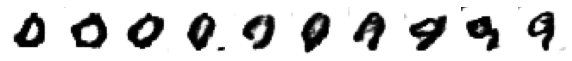

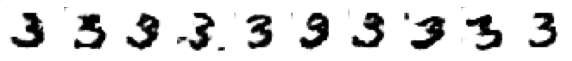

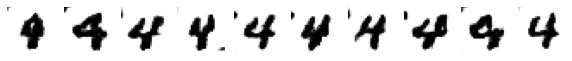

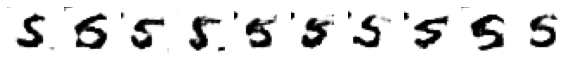

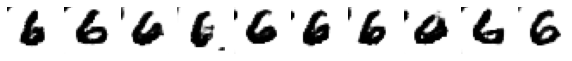

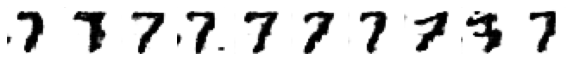

In [ ]:
'''
11.　訓練済みの生成器でフェイク画像を生成
'''
# 正解ラベル0と9を設定
fake_2 = interpolate_class(0, 9)
fake_2 *= 255.0
plot_multiple_images(fake_2, 10) # 1行に10枚ずつ出力
# 正解ラベル3を設定
fake_3 = interpolate_class(3, 3)
fake_3 *= 255.0
plot_multiple_images(fake_3, 10) # 1行に10枚ずつ出力
# 正解ラベル4を設定
fake_4 = interpolate_class(4, 4)
fake_4 *= 255.0
plot_multiple_images(fake_4, 10) # 1行に10枚ずつ出力
# 正解ラベル5を設定
fake_5 = interpolate_class(5, 5)
fake_5 *= 255.0
plot_multiple_images(fake_5, 10) # 1行に10枚ずつ出力
# 正解ラベル6を設定
fake_5 = interpolate_class(6, 6)
fake_5 *= 255.0
plot_multiple_images(fake_5, 10) # 1行に10枚ずつ出力
# 正解ラベル7を設定
fake_5 = interpolate_class(7, 7)
fake_5 *= 255.0
plot_multiple_images(fake_5, 10) # 1行に10枚ずつ出力